 Pada dasarnya, dalam transfer learning, yang ditransfer adalah representasi fitur tingkat tinggi (feature representations) yang telah dipelajari oleh lapisan-lapisan awal (convolutional layers) dari model yang telah dilatih sebelumnya. Ini berarti model yang telah dilatih sebelumnya telah berhasil mengekstraksi fitur-fitur umum dari data yang relevan dengan tugas tertentu, dan kita ingin menggunakan pengetahuan ini untuk membantu tugas baru.

Dengan kata lain, lapisan-lapisan awal dari model (biasanya yang terkait dengan ekstraksi fitur) adalah yang paling berguna dalam transfer learning. Ketika kita menggunakan model ini untuk tugas baru, kita dapat mempertahankan representasi fitur yang sudah terlatih sebelumnya, sementara kita mem-optimalkan lapisan-lapisan terakhir (biasanya fully connected layers) untuk tugas spesifik yang ingin kita selesaikan.

Jadi, bahwa yang ditransfer adalah kemampuan model untuk mengekstrak fitur-fitur yang berguna dari data, dan kemudian penyesuaian dilakukan pada lapisan-lapisan klasifikasi untuk membuat prediksi yang sesuai dengan tugas baru.

# Preliminary Codes

Import Necessary Libraries

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
from IPython.display import display

# Filter harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [11]:
!gdown 1Ui6CVLdoAMp0qyJP1xpMwUGOi0couST- #https://drive.google.com/file/d/1Ui6CVLdoAMp0qyJP1xpMwUGOi0couST-/view
!unzip -q /content/hymenoptera_data

Downloading...
From: https://drive.google.com/uc?id=1Ui6CVLdoAMp0qyJP1xpMwUGOi0couST-
To: /content/hymenoptera_data.zip
100% 47.3M/47.3M [00:00<00:00, 57.1MB/s]


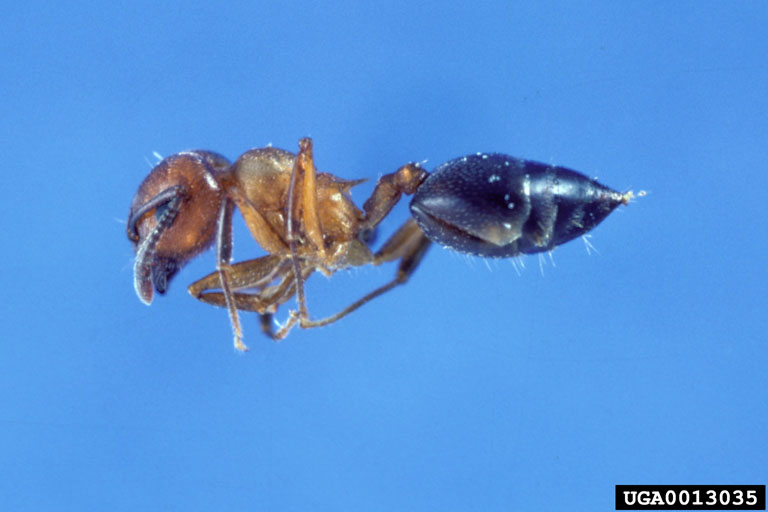

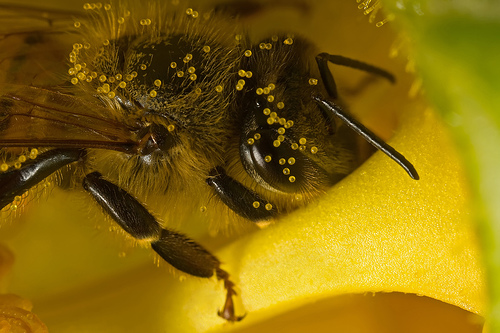

In [15]:
with Image.open('hymenoptera_data/train/ants/0013035.jpg') as im:
    display(im)
with Image.open('hymenoptera_data/train/bees/1092977343_cb42b38d62.jpg')  as im:
    display(im)

In [16]:
data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

['ants', 'bees']


In [17]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

In [18]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

In [19]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

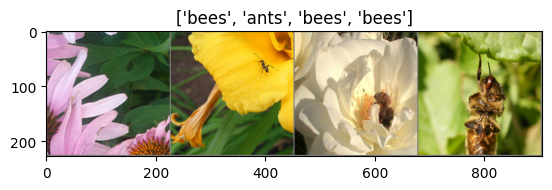

In [20]:
imshow(out, title=[class_names[x] for x in classes])

In [24]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [27]:
#### Finetuning the convnet ####
# Load a pretrained model and reset final fully connected layer.

model = models.resnet18(pretrained=True) #aktifkan pretrained
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)

criterion = nn.CrossEntropyLoss()

In [28]:
#tanpa freezing semua layers

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6433 Acc: 0.5943
val Loss: 0.4864 Acc: 0.8105

Epoch 1/24
----------
train Loss: 0.5242 Acc: 0.7459
val Loss: 0.3726 Acc: 0.8693

Epoch 2/24
----------
train Loss: 0.4701 Acc: 0.7951
val Loss: 0.3214 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.4156 Acc: 0.8361
val Loss: 0.2984 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.4069 Acc: 0.8279
val Loss: 0.2700 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.3316 Acc: 0.8566
val Loss: 0.2524 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.4379 Acc: 0.7828
val Loss: 0.2523 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.3915 Acc: 0.8033
val Loss: 0.2554 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.3605 Acc: 0.8484
val Loss: 0.2446 Acc: 0.8954

Epoch 9/24
----------
train Loss: 0.3664 Acc: 0.8156
val Loss: 0.2330 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.3340 Acc: 0.8730
val Loss: 0.2276 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.3793 Acc: 0.7910
val Loss: 0.2156 Acc: 0.9412

Ep

In [29]:
#freez semua layers, kecuali fully connected layer (fc)

#### ConvNet as fixed feature extractor ####
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5836 Acc: 0.7049
val Loss: 0.2197 Acc: 0.9477

Epoch 1/24
----------
train Loss: 0.4919 Acc: 0.8115
val Loss: 0.1789 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.5363 Acc: 0.7336
val Loss: 0.1642 Acc: 0.9542

Epoch 3/24
----------
train Loss: 0.4814 Acc: 0.8115
val Loss: 0.3753 Acc: 0.8431

Epoch 4/24
----------
train Loss: 0.5835 Acc: 0.7787
val Loss: 0.2128 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.4463 Acc: 0.8033
val Loss: 0.1783 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.5558 Acc: 0.7869
val Loss: 0.7042 Acc: 0.7843

Epoch 7/24
----------
train Loss: 0.4274 Acc: 0.8279
val Loss: 0.2146 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3689 Acc: 0.8443
val Loss: 0.1935 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.3057 Acc: 0.8566
val Loss: 0.2184 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.3768 Acc: 0.8238
val Loss: 0.2179 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.2776 Acc: 0.8730
val Loss: 0.2350 Acc: 0.9346

Ep

# Update the Codes (1)

In [30]:
#dataset loader telah didefinisikan

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [32]:
# Definisi transformasi dan lokasi dataset
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [33]:
data_dir = 'hymenoptera_data'

# Buat dataset
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

# Buat data loader
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=0) for x in ['train', 'val']}

# Ambil ukuran dataset
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# Ambil nama kelas
class_names = image_datasets['train'].classes

# Cek apakah GPU (cuda) tersedia
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(class_names)

['ants', 'bees']


In [36]:
# Fungsi untuk menampilkan gambar
def imshow(inp, title):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.25, 0.25, 0.25])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

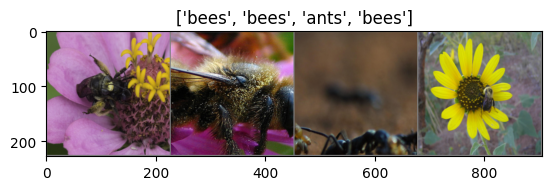

In [37]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [38]:
# Fungsi untuk membuat plot perbandingan akurasi
def plot_comparison(all_layers_acc, fc_only_acc, num_epochs):
    epochs = range(1, num_epochs + 1)

    plt.plot(epochs, all_layers_acc, label='All Layers')
    plt.plot(epochs, fc_only_acc, label='FC Layers Only')

    plt.title('Comparison of Transfer Learning Strategies')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.show()

In [39]:
# Fungsi untuk mendapatkan akurasi dari setiap epoch
def get_epoch_accuracies(model, dataloaders, dataset_sizes, device):
    accuracies = {'train': [], 'val': []}

    for phase in ['train', 'val']:
        model.eval() if phase == 'val' else model.train()
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels.data)

        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        accuracies[phase].append(epoch_acc.item())

    return accuracies

In [40]:
# Fungsi untuk melatih model dan mendapatkan akurasi setiap epoch
def train_model_and_get_accuracies(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, device, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    epoch_accuracies = {'train': [], 'val': []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            epoch_accuracies[phase].append(epoch_acc.item())

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, epoch_accuracies

In [41]:
# Fine-tuning seluruh model
model_all_layers = models.resnet18(pretrained=True)
model_all_layers.fc = nn.Linear(model_all_layers.fc.in_features, 2)
model_all_layers = model_all_layers.to(device)
optimizer_all_layers = optim.SGD(model_all_layers.parameters(), lr=0.001)
step_lr_scheduler_all_layers = lr_scheduler.StepLR(optimizer_all_layers, step_size=7, gamma=0.1)
model_all_layers, all_layers_accuracies = train_model_and_get_accuracies(model_all_layers, criterion, optimizer_all_layers,
                                                                         step_lr_scheduler_all_layers, dataloaders, dataset_sizes, device, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7025 Acc: 0.5533
val Loss: 0.5447 Acc: 0.7451

Epoch 1/24
----------
train Loss: 0.5504 Acc: 0.6926
val Loss: 0.4087 Acc: 0.8693

Epoch 2/24
----------
train Loss: 0.5139 Acc: 0.7623
val Loss: 0.3433 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.4396 Acc: 0.7992
val Loss: 0.2880 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.3964 Acc: 0.8033
val Loss: 0.2706 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.4256 Acc: 0.7746
val Loss: 0.2589 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.4263 Acc: 0.7951
val Loss: 0.2381 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.3422 Acc: 0.8525
val Loss: 0.2319 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.3723 Acc: 0.8320
val Loss: 0.2355 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.3292 Acc: 0.8730
val Loss: 0.2379 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.3371 Acc: 0.8566
val Loss: 0.2432 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.3660 Acc: 0.8361
val Loss: 0.2341 Acc: 0.9346

Ep

In [42]:
# Transfer learning hanya FC layers
model_fc_only = torchvision.models.resnet18(pretrained=True)
for param in model_fc_only.parameters():
    param.requires_grad = False
model_fc_only.fc = nn.Linear(model_fc_only.fc.in_features, 2)
model_fc_only = model_fc_only.to(device)
optimizer_fc_only = optim.SGD(model_fc_only.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler_fc_only = lr_scheduler.StepLR(optimizer_fc_only, step_size=7, gamma=0.1)
model_fc_only, fc_only_accuracies = train_model_and_get_accuracies(model_fc_only, criterion, optimizer_fc_only,
                                                                   exp_lr_scheduler_fc_only, dataloaders, dataset_sizes, device, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7077 Acc: 0.6311
val Loss: 0.3185 Acc: 0.8366

Epoch 1/24
----------
train Loss: 0.6599 Acc: 0.7500
val Loss: 0.4036 Acc: 0.8301

Epoch 2/24
----------
train Loss: 0.5684 Acc: 0.7623
val Loss: 0.2183 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.5062 Acc: 0.7746
val Loss: 0.2217 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.6157 Acc: 0.7049
val Loss: 0.1894 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.4426 Acc: 0.7869
val Loss: 0.2639 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.4492 Acc: 0.8115
val Loss: 0.2228 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.3254 Acc: 0.8648
val Loss: 0.1991 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3692 Acc: 0.8402
val Loss: 0.1929 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.4473 Acc: 0.8074
val Loss: 0.1993 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3651 Acc: 0.8443
val Loss: 0.2025 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.2796 Acc: 0.8730
val Loss: 0.1956 Acc: 0.9412

Ep

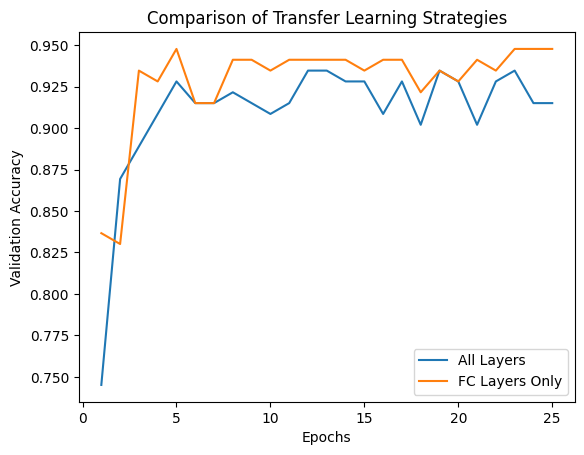

In [43]:
# Ekstrak akurasi
all_layers_acc = all_layers_accuracies['val']
fc_only_acc = fc_only_accuracies['val']

# Plot perbandingan akurasi
plot_comparison(all_layers_acc, fc_only_acc, num_epochs=25)

# Update the Codes (2)

['ants', 'bees']
Epoch 0/24
----------
train Loss: 0.6846 Acc: 0.5943
val Loss: 0.5052 Acc: 0.7778

Epoch 1/24
----------
train Loss: 0.6041 Acc: 0.7254
val Loss: 0.3988 Acc: 0.8824

Epoch 2/24
----------
train Loss: 0.5436 Acc: 0.7377
val Loss: 0.3359 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.5392 Acc: 0.7090
val Loss: 0.2994 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.4384 Acc: 0.8074
val Loss: 0.3020 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.4686 Acc: 0.7992
val Loss: 0.2512 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.4357 Acc: 0.7869
val Loss: 0.2392 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.4593 Acc: 0.8033
val Loss: 0.2402 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.4281 Acc: 0.8115
val Loss: 0.2329 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3535 Acc: 0.8730
val Loss: 0.2276 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.4088 Acc: 0.8279
val Loss: 0.2287 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.4328 Acc: 0.7869
val Loss: 0.231

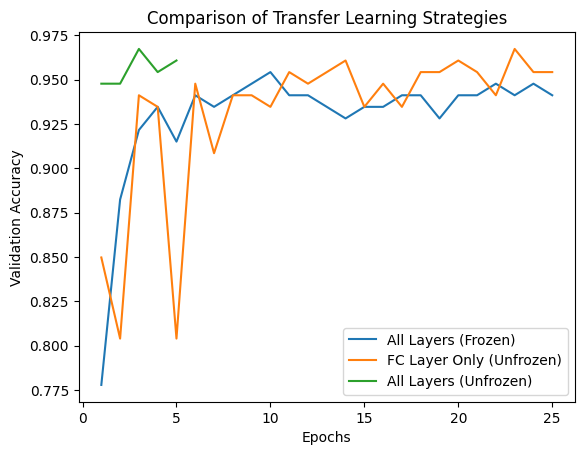

In [70]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

# Definisi transformasi dan lokasi dataset
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_dir = 'hymenoptera_data'

# Buat dataset
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

# Buat data loader
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=0) for x in ['train', 'val']}

# Ambil ukuran dataset
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# Ambil nama kelas
class_names = image_datasets['train'].classes

# Cek apakah GPU (cuda) tersedia
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(class_names)

# Fungsi untuk membuat plot perbandingan akurasi
def plot_comparison(all_layers_acc, fc_only_acc, unfreeze_acc, num_epochs):
    epochs = range(1, num_epochs + 1)

    plt.plot(epochs, all_layers_acc, label='All Layers (Frozen)')
    plt.plot(epochs, fc_only_acc, label='FC Layer Only (Unfrozen)')

    if unfreeze_acc:  # Cek apakah ada data untuk plot unfreeze
        plt.plot(range(1, len(unfreeze_acc) + 1), unfreeze_acc, label='All Layers (Unfrozen)')

    plt.title('Comparison of Transfer Learning Strategies')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.show()

# Fungsi untuk mendapatkan akurasi dari setiap epoch
def get_epoch_accuracies(model, dataloaders, dataset_sizes, device):
    accuracies = {'train': [], 'val': []}

    for phase in ['train', 'val']:
        model.eval() if phase == 'val' else model.train()
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels.data)

        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        accuracies[phase].append(epoch_acc.item())

    return accuracies

# Fungsi untuk melatih model dan mendapatkan akurasi setiap epoch
def train_model_and_get_accuracies(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, device, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    epoch_accuracies = {'train': [], 'val': []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            epoch_accuracies[phase].append(epoch_acc.item())

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        # Simpan model setiap beberapa epoch
        if (epoch + 1) % 5 == 0:
            torch.save(model.state_dict(), f'model_epoch_{epoch + 1}.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, epoch_accuracies

# Load pre-trained ResNet18 model
model_all_layers = models.resnet18(pretrained=True)

# Freeze all layers
for param in model_all_layers.parameters():
    param.requires_grad = False

# Modify the fully connected layer to have 2 output classes
model_all_layers.fc = nn.Linear(model_all_layers.fc.in_features, 2)

# Move the model to the appropriate device
model_all_layers = model_all_layers.to(device)

# Define the loss function
criterion_all_layers = nn.CrossEntropyLoss()

# Observe that only parameters of the final layer are being optimized
optimizer_all_layers = optim.SGD(model_all_layers.fc.parameters(), lr=0.001)

# Learning rate scheduler
scheduler_all_layers = lr_scheduler.StepLR(optimizer_all_layers, step_size=7, gamma=0.1)

# Train the model with all layers frozen
model_all_layers, all_layers_accuracies = train_model_and_get_accuracies(
    model_all_layers, criterion_all_layers, optimizer_all_layers, scheduler_all_layers,
    dataloaders, dataset_sizes, device, num_epochs=25)

# Unfreeze all layers after training for n epochs
unfreeze_epochs = 5
unfreeze_accuracies = []  # List untuk menyimpan akurasi pada setiap epoch unfreeze

for epoch in range(unfreeze_epochs):
    # Ensure the model is in training mode before unfreezing layers
    model_all_layers.train()

    # Unfreeze all layers
    for param in model_all_layers.parameters():
        param.requires_grad = True

    model_all_layers, _ = train_model_and_get_accuracies(
        model_all_layers, nn.CrossEntropyLoss(),
        optim.SGD(model_all_layers.parameters(), lr=0.001),
        lr_scheduler.StepLR(optimizer_all_layers, step_size=7, gamma=0.1),
        dataloaders, dataset_sizes, device, num_epochs=1)

    # Get and append accuracy after unfreezing
    accuracies = get_epoch_accuracies(model_all_layers, dataloaders, dataset_sizes, device)
    unfreeze_accuracies.extend(accuracies['val'])

# Load pre-trained ResNet18 model
model_fc_only = models.resnet18(pretrained=True)

# Modify the fully connected layer to have 2 output classes
model_fc_only.fc = nn.Linear(model_fc_only.fc.in_features, 2)

# Move the model to the appropriate device
model_fc_only = model_fc_only.to(device)

# Define the loss function
criterion_fc_only = nn.CrossEntropyLoss()

# Observe that only parameters of the final layer are being optimized
optimizer_fc_only = optim.SGD(model_fc_only.fc.parameters(), lr=0.001, momentum=0.9)

# Learning rate scheduler
scheduler_fc_only = lr_scheduler.StepLR(optimizer_fc_only, step_size=7, gamma=0.1)

# Train the model with only fully connected layers unfrozen
model_fc_only, fc_only_accuracies = train_model_and_get_accuracies(
    model_fc_only, criterion_fc_only, optimizer_fc_only, scheduler_fc_only,
    dataloaders, dataset_sizes, device, num_epochs=25)

# Extract accuracies
all_layers_acc = all_layers_accuracies['val']
fc_only_acc = fc_only_accuracies['val']

# Plot the comparison
plot_comparison(all_layers_acc, fc_only_acc, unfreeze_accuracies, num_epochs=25)


1. All Layers (Frozen): No layers are optimized through transfer learning. All layers, including convolutional or feature layers, are frozen, and only the fully connected layer is optimized for the specific task.

2. FC Layer Only (Unfrozen): Only the fully connected layer is optimized through transfer learning. Other layers, such as convolutional layers, remain unchanged (not frozen).

3. All Layers (Unfrozen): All layers are optimized through transfer learning. This includes both convolutional layers (feature layers) and the fully connected layer.

-. With the All Layers (Frozen) strategy, the model leverages common features learned by the pre-trained model, and only fine-tunes the fully connected layer to adapt the model to the new classification task. This strategy is useful when the new dataset is small or similar to the original dataset used for pre-training.

-. The FC Layer Only (Unfrozen) strategy is useful when we want to utilize the knowledge learned by the pre-trained model in the feature part (convolutional layers) but want to adjust the fully connected layer for a different classification task.

-. The All Layers (Unfrozen) strategy is beneficial when we have a sufficiently large and significantly different dataset from the original one. In this case, we allow the entire model to adapt to the new dataset.